In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44091 sha256=b298bce9a76ac008395a0eff4b92d348d4ca6aebcafcb9bde65b3eb1bee76867
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask 2023.7.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
dask-cuda 23.6.0 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
dask-cudf 23.6.

In [78]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  2.0.0
detectron2: 0.6


In [79]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import cv2
from matplotlib import pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [80]:
%%capture
# detectron2
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.utils.logger import setup_logger
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm  # progress bar
import matplotlib.pyplot as plt
import json
import cv2
import copy
from typing import Optional
import seaborn as sns

!pip install -q pycocotools
from pycocotools.coco import COCO
from PIL import Image
import random
from pathlib import Path
%matplotlib inline
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)

from IPython.display import FileLink
# torch
import torch
import gc
import warnings
# Ignore "future" warnings and Data-Frame-Slicing warnings.
warnings.filterwarnings('ignore')

setup_logger()

In [81]:
from pathlib import Path

TRAIN_IMG_DIR = Path("/kaggle/input/dlsprint2/badlad/images/train")

TRAIN_COCO_PATH = Path("/kaggle/input/dlsprint2/badlad/labels/coco_format/train/badlad-train-coco.json")

TEST_IMG_DIR = Path("/kaggle/input/dlsprint2/badlad/images/test")

TEST_METADATA_PATH = Path("/kaggle/input/dlsprint2/badlad/badlad-test-metadata.json")

# Training output directory
OUTPUT_DIR = Path("./output")
OUTPUT_MODEL = OUTPUT_DIR/"model_final.pth"


# Path to your pretrained model weights 
PRETRAINED_PATH = Path("/kaggle/input/output/model_final (6).pth")

In [82]:
with TRAIN_COCO_PATH.open() as f:
    train_dict = json.load(f)

with TEST_METADATA_PATH.open() as f:
    test_dict = json.load(f)
    
train_coco_labels=COCO(annotation_file=TRAIN_COCO_PATH)

print("#### LABELS AND METADATA LOADED ####")

loading annotations into memory...
Done (t=6.35s)
creating index...
index created!
#### LABELS AND METADATA LOADED ####


In [83]:
from datetime import datetime

# if False, model is set to `PRETRAINED_PATH` model
is_train = True

# if True, evaluate on validation dataset
is_evaluate = True

# if True, run inference on test dataset
is_inference = False

# if True and `is_train` == True, `PRETRAINED_PATH` model is trained further
is_resume_training = True

# Perform augmentation
is_augment = False

SEED = int(datetime.now().timestamp())

# Model path based on Decisions
MODEL_PATH = OUTPUT_MODEL if is_train else PRETRAINED_PATH

In [84]:
print("There are " + str(len(train_dict['categories'])) + " categories.\n")
print("There are " + str(len(test_dict['images']) + len(train_dict['images'])) + " images in the dataset.")
print("There are " + str(len(train_dict['images'])) + " images in the train set.")
print("There are " + str(len(test_dict['images'])) + " images in the test set.\n")
print("There are " + str(len(train_dict['annotations'])) + " annotations in the train set.\n")

print("We will focus on mainly categories, images and annotations.")

There are 4 categories.

There are 33365 images in the dataset.
There are 20365 images in the train set.
There are 13000 images in the test set.

There are 425101 annotations in the train set.

We will focus on mainly categories, images and annotations.


In [85]:
def organize_coco_data(data_dict: dict) -> tuple[list[str], list[dict], list[dict]]:
    thing_classes: list[str] = []

    # Map Category Names to IDs
    for cat in data_dict['categories']:
        thing_classes.append(cat['name'])

    # Images
    images_metadata: list[dict] = data_dict['images']

    # Convert COCO annotations to detectron2 annotations format
    data_annotations = []
    for ann in data_dict['annotations']:
        # coco format -> detectron2 format
        annot_obj = {
            # Annotation ID
            "id": ann['id'],

            # Segmentation Polygon (x, y) coordinnates
            "gt_masks": ann['segmentation'],

            # Image ID for this annotation (Which image does this annotation belong to?)
            "image_id": ann['image_id'],

            # Category Label (0: paragraph, 1: text box, 2: image, 3: table)
            "category_id": ann['category_id'],

            "x_min": ann['bbox'][0],  # left
            "y_min": ann['bbox'][1],  # top
            "x_max": ann['bbox'][0] + ann['bbox'][2],  # left+width
            "y_max": ann['bbox'][1] + ann['bbox'][3]  # top+height
        }
        data_annotations.append(annot_obj)

    return thing_classes, images_metadata, data_annotations

In [86]:
thing_classes, images_metadata, data_annotations = organize_coco_data(train_dict)

thing_classes_test, images_metadata_test, _ = organize_coco_data(test_dict)

print(thing_classes)

['paragraph', 'text_box', 'image', 'table']


In [87]:
train_metadata = pd.DataFrame(images_metadata)
train_metadata = train_metadata[['id', 'file_name', 'width', 'height']]
train_metadata = train_metadata.rename(columns={"id": "image_id"})
print("train_metadata size=", len(train_metadata))
train_metadata.head(5)

train_metadata size= 20365


image_id                                 file_name  width  height
0         0  846df66a-610e-4356-b369-6788885a0dc5.png    720     995
1         1  ac85875b-7d47-4072-8663-d65f7c5c58bd.png   1700    2800
2         2  12f55392-4b58-4e62-b879-057554734a29.png   1700    2800
3         3  da7472db-1f45-4ff0-834c-b018dbbed3c2.png   1700    2800
4         4  ff06ef6e-d551-4be7-b06c-16bc9b865b82.png    480     800

In [88]:
train_annot_df = pd.DataFrame(data_annotations)
print("train_annot_df size=", len(train_annot_df))
train_annot_df.head(5)

train_annot_df size= 425101


id                                           gt_masks  image_id  \
0   0  [[86.328, 179.007, 657.662, 183.008, 654.662, ...         0   
1   1  [[102.995, 281.675, 657.328, 281.675, 652.995,...         0   
2   2  [[509.995, 539.345, 602.328, 543.012, 599.662,...         0   
3   3  [[273.995, 18.006, 443.995, 20.006, 433.662, 1...         0   
4   4  [[540.995, 88.673, 647.328, 89.006, 647.995, 1...         0   

   category_id  x_min  y_min  x_max  y_max  
0            0   56.0  179.0  657.0  277.0  
1            0   54.0  281.0  657.0  378.0  
2            2  509.0  539.0  666.0  585.0  
3            1  273.0   18.0  443.0  101.0  
4            1  540.0   88.0  647.0  129.0

In [89]:
test_metadata = pd.DataFrame(images_metadata_test)
test_metadata = test_metadata[['id', 'file_name', 'width', 'height']]
test_metadata = test_metadata.rename(columns={"id": "image_id"})
print("test_metadata size=", len(test_metadata))
test_metadata.head(5)

test_metadata size= 13000


image_id                                 file_name  width  height
0         0  96eee398-1275-4768-be89-ec945e6c8bb0.png    720    1018
1         1  9b77c241-8292-4133-ab7a-0398a99f30a8.png    720    1019
2         2  3a6ac54b-d3f6-4783-9f71-b6ae29c93f7d.png    720    1105
3         3  2d0e29cd-83cb-4426-9663-1368c1975c37.png   1080    1920
4         4  f8c22a4a-6c89-4179-8845-12405bfd0035.png   1080    1920

In [90]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_image(_image_id):
    image_file = train_coco_labels.loadImgs([_image_id])[0]['file_name']
    image = Image.open(TRAIN_IMG_DIR/image_file)
    plt.imshow(np.asarray(image))
    plt.axis('off')

def show_multiple_images(image_ids):
    num_images = len(image_ids)
    num_cols = 2
    num_rows = num_images

    fig = plt.figure(figsize=(15, 15 * num_rows))

    for i, image_id in enumerate(image_ids, start=1):  # Use 1-based indexing
        fig.add_subplot(num_rows, num_cols, i)
        show_image(image_id)

    plt.subplots_adjust(hspace=0.2)  # Adjust the vertical space between images
    plt.show()




In [91]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_segmentations(_image_id):
    show_image(_image_id)
    annotation_ids = train_coco_labels.getAnnIds(imgIds=[_image_id])
    annotations = train_coco_labels.loadAnns(annotation_ids)
    train_coco_labels.showAnns(annotations)

def show_multiple_segmentations(image_ids):
    num_images = len(image_ids)
    num_cols = 2
    num_rows = num_images

    fig = plt.figure(figsize=(15, 15 * num_rows))

    for i, image_id in enumerate(image_ids, start=1):  # Use 1-based indexing
        fig.add_subplot(num_rows, num_cols, i)
        show_segmentations(image_id)

    plt.subplots_adjust(hspace=0.2)  # Adjust the vertical space between images
    plt.show()



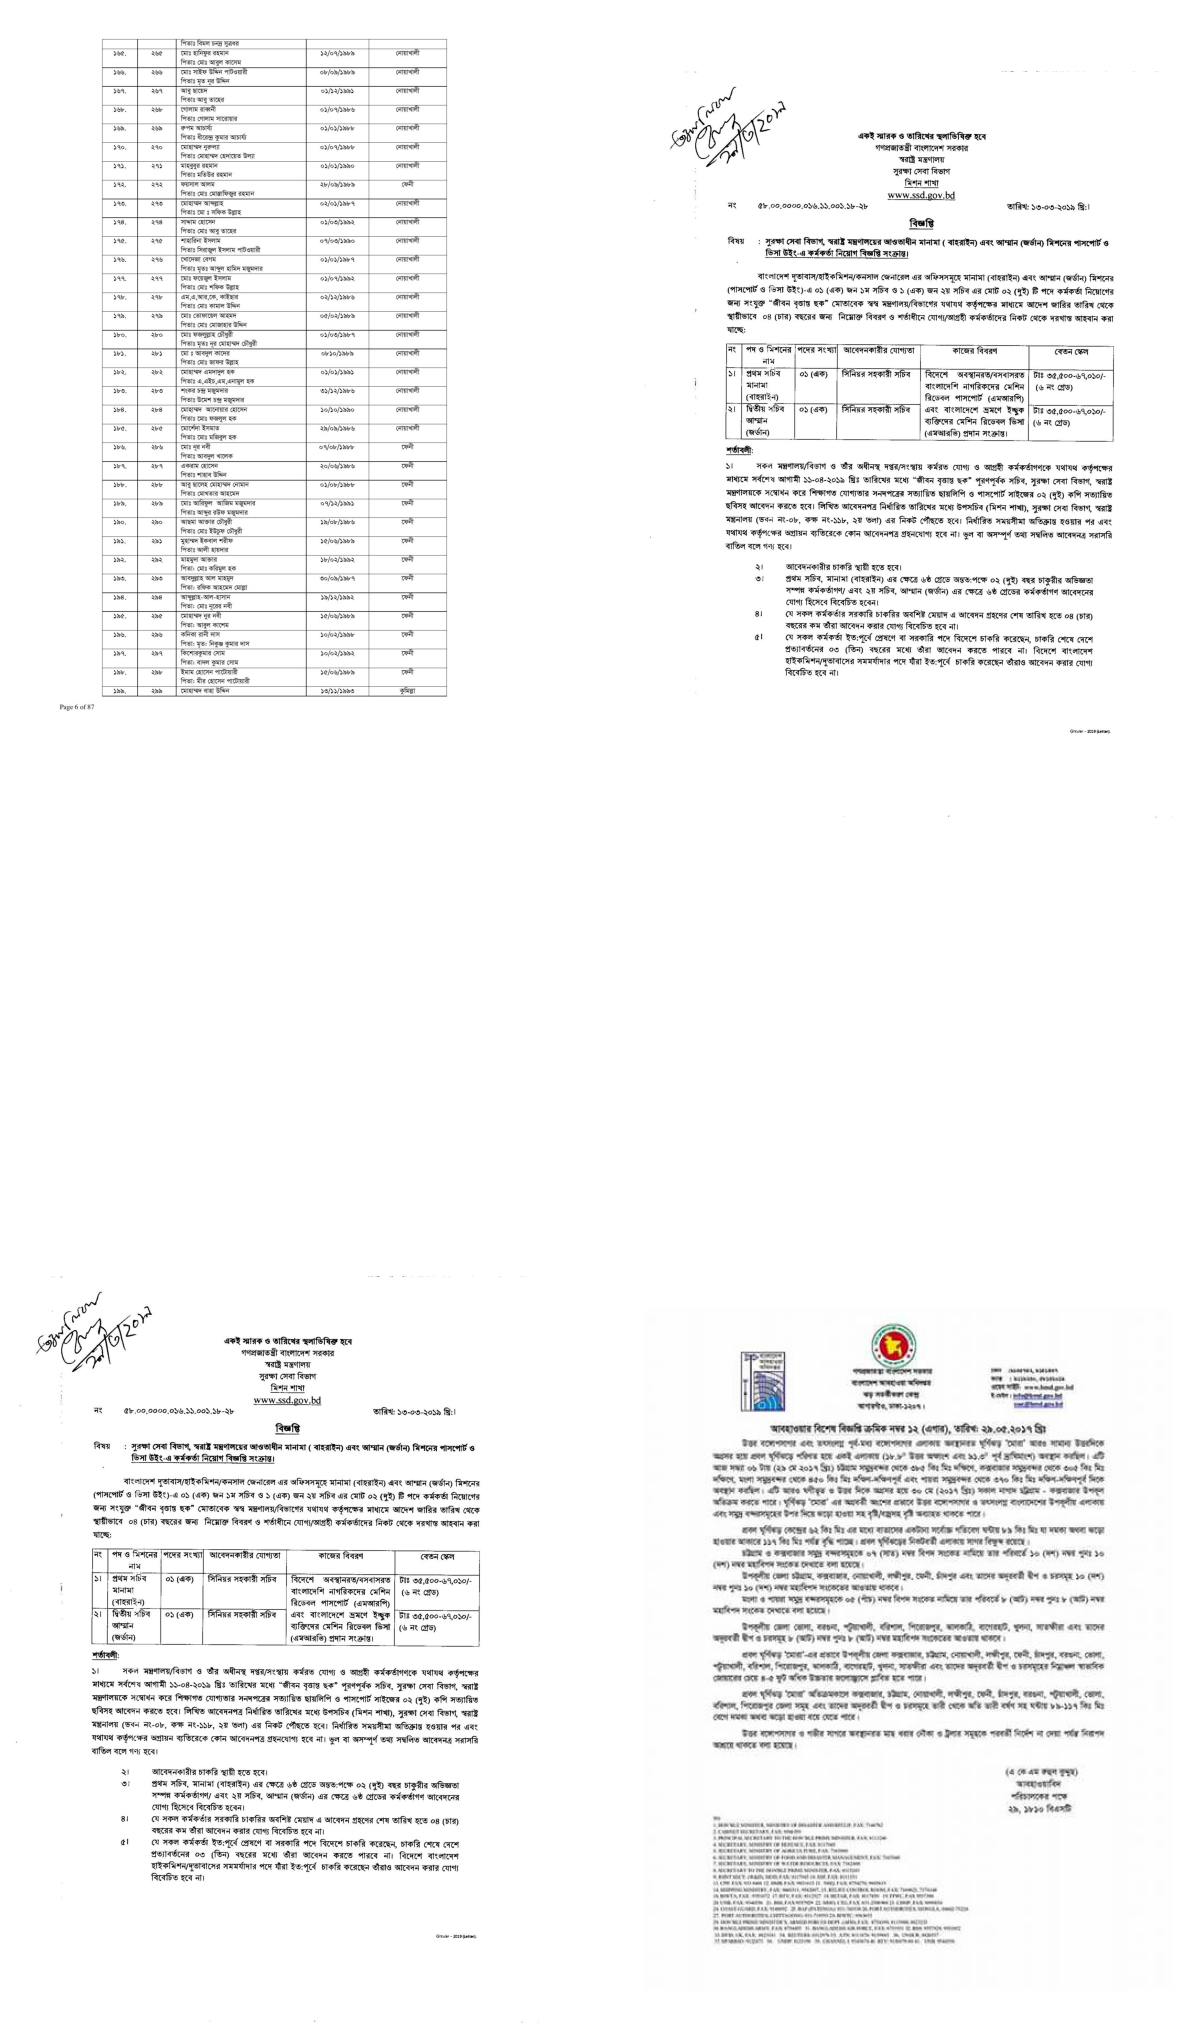

In [92]:
# Example usage
image_ids = [60, 20, 20,80]  # Replace with the image IDs you want to display
show_multiple_images(image_ids)

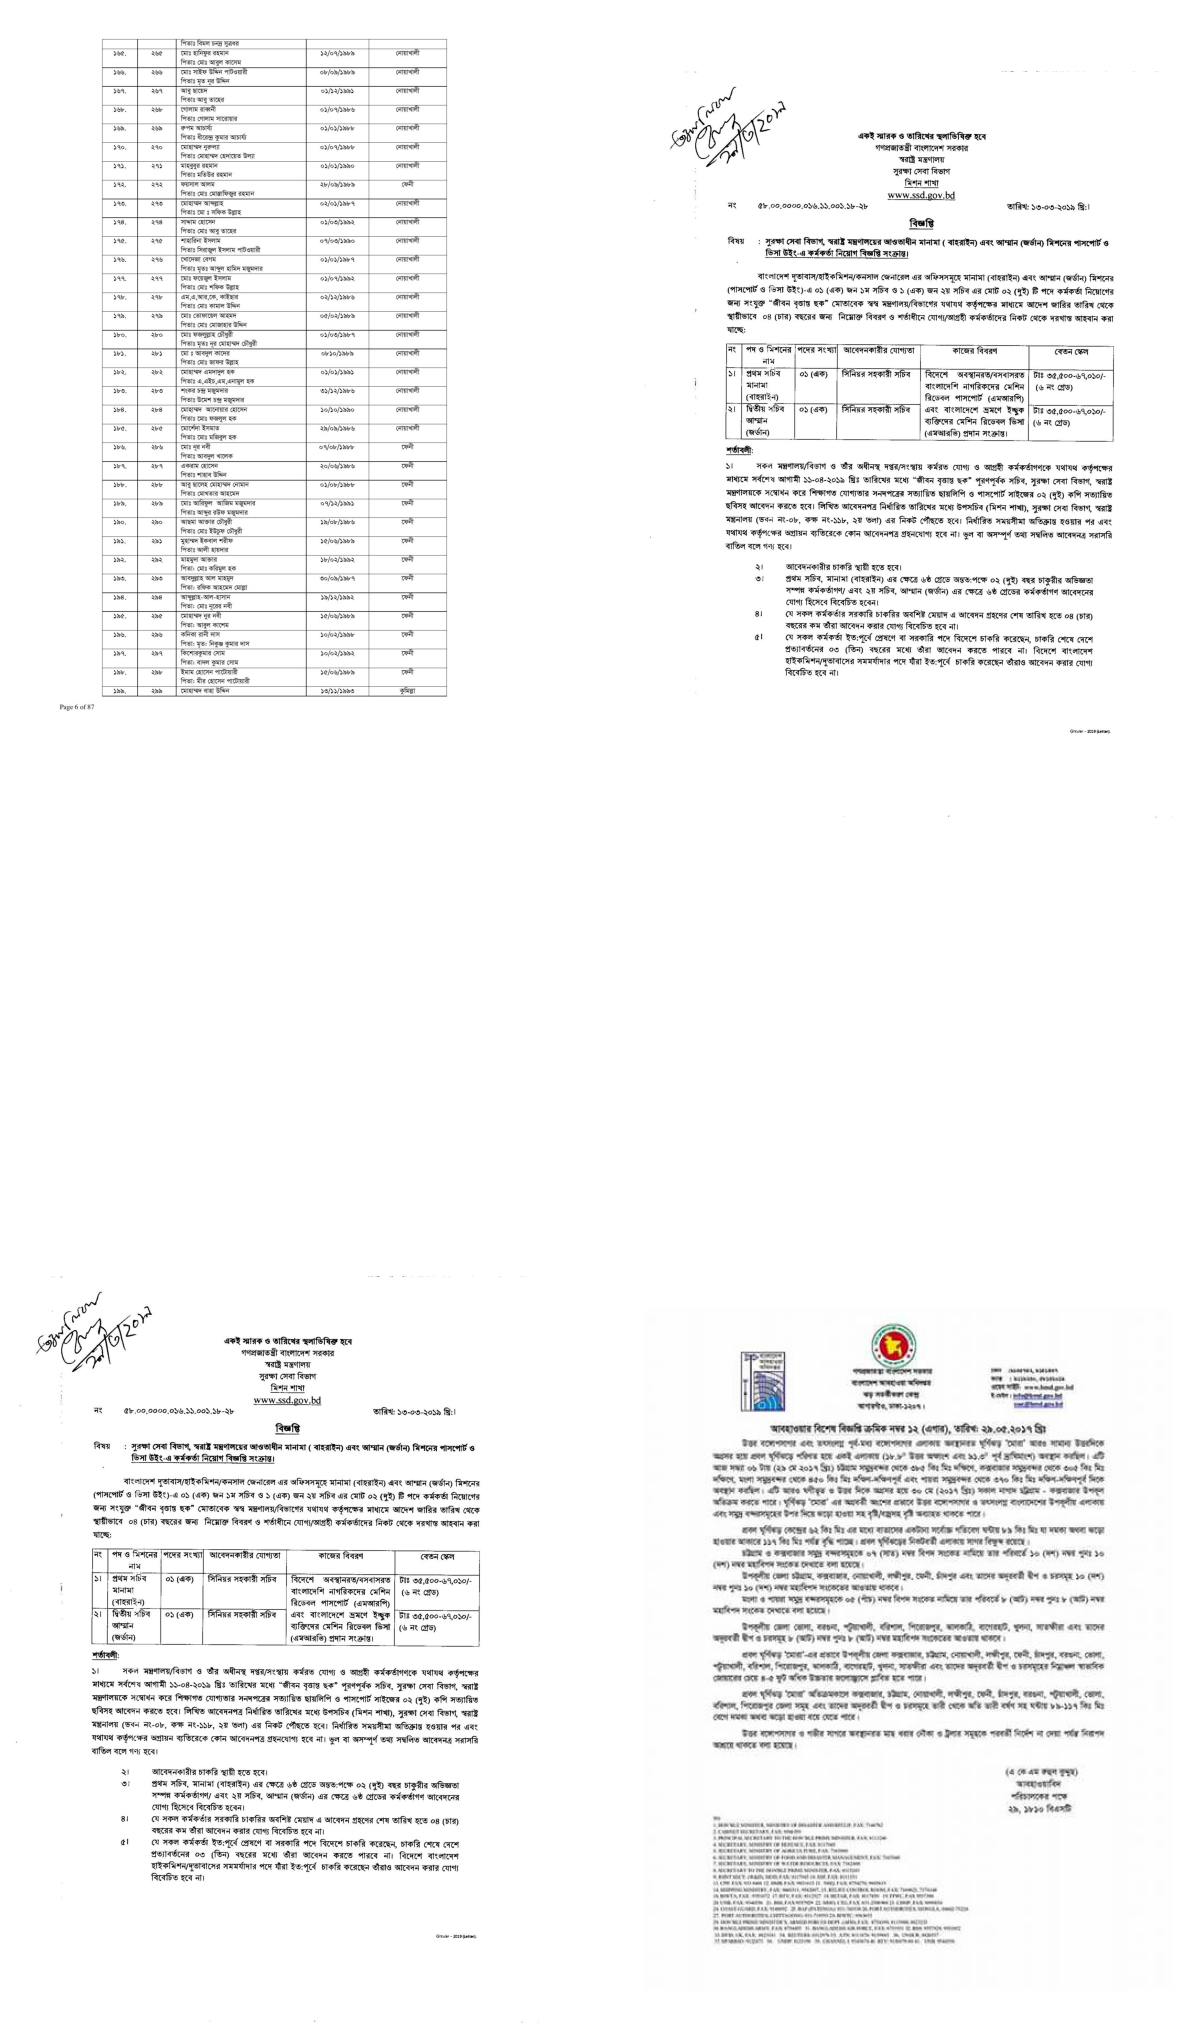

In [93]:
# Example usage
image_ids = [60, 20, 20,80]  # Replace with the image IDs you want to display
show_multiple_segmentations(image_ids)

In [94]:
train_annotations = pd.DataFrame(train_dict['annotations'])
#train_annotations.head()

In [95]:
# adding bbox_area and bbox_aspect_ratio
print("\nRenaming id to annotation_id.\nAdding bbox_area, bbox_aspect_ratio.\n")
train_annotations.rename(columns={"id":"annotation_id"}, inplace=True)
bbox_area=[]
bbox_aspect_ratio=[]
for idx in train_annotations.index:
    bbox_area.append(train_annotations['bbox'][idx][3]*train_annotations['bbox'][idx][2])
    bbox_aspect_ratio.append(train_annotations['bbox'][idx][3]/train_annotations['bbox'][idx][2])
train_annotations['bbox_area']=bbox_area
train_annotations['bbox_aspect_ratio']=bbox_aspect_ratio
print("train_annotations shape: " + str(train_annotations.shape) + "\n")
train_annotations.head()


Renaming id to annotation_id.
Adding bbox_area, bbox_aspect_ratio.

train_annotations shape: (425101, 9)



segmentation  iscrowd          area  \
0  [[86.328, 179.007, 657.662, 183.008, 654.662, ...        0  56127.746389   
1  [[102.995, 281.675, 657.328, 281.675, 652.995,...        0  54447.221499   
2  [[509.995, 539.345, 602.328, 543.012, 599.662,...        0   4945.071445   
3  [[273.995, 18.006, 443.995, 20.006, 433.662, 1...        0  12891.525055   
4  [[540.995, 88.673, 647.328, 89.006, 647.995, 1...        0   4300.942833   

   image_id  category_id  annotation_id                         bbox  \
0         0            0              0   [56.0, 179.0, 601.0, 98.0]   
1         0            0              1   [54.0, 281.0, 603.0, 97.0]   
2         0            2              2  [509.0, 539.0, 157.0, 46.0]   
3         0            1              3   [273.0, 18.0, 170.0, 83.0]   
4         0            1              4   [540.0, 88.0, 107.0, 41.0]   

   bbox_area  bbox_aspect_ratio  
0    58898.0           0.163062  
1    58491.0           0.160862  
2     7222.0           0.292994  
3    14110.0           0.488235  
4     4387.0           0.383178

In [96]:
#train_annotations.describe()

In [97]:
train_categories = pd.DataFrame(train_dict['categories'])

print("Dropping supercategory.\nRenaming id to category_id.\n")
train_categories.drop('supercategory', axis=1, inplace=True)
train_categories.rename(columns={"id":"category_id"}, inplace=True)
train_categories

Dropping supercategory.
Renaming id to category_id.



category_id       name
0            0  paragraph
1            1   text_box
2            2      image
3            3      table

In [98]:
img_cat_count = train_annotations[['image_id', 'category_id']].copy()
category_names=[]
for idx in img_cat_count.index:
    category_names.append(train_categories['name'][img_cat_count['category_id'][idx]])
img_cat_count['category_name']=category_names
img_cat_count[train_categories['name'][0]] = img_cat_count['category_id'] == train_categories['category_id'][0]
img_cat_count[train_categories['name'][1]] = img_cat_count['category_id'] == train_categories['category_id'][1]
img_cat_count[train_categories['name'][2]] = img_cat_count['category_id'] == train_categories['category_id'][2]
img_cat_count[train_categories['name'][3]] = img_cat_count['category_id'] == train_categories['category_id'][3]
img_cat_count.head()

image_id  category_id category_name  paragraph  text_box  image  table
0         0            0     paragraph       True     False  False  False
1         0            0     paragraph       True     False  False  False
2         0            2         image      False     False   True  False
3         0            1      text_box      False      True  False  False
4         0            1      text_box      False      True  False  False

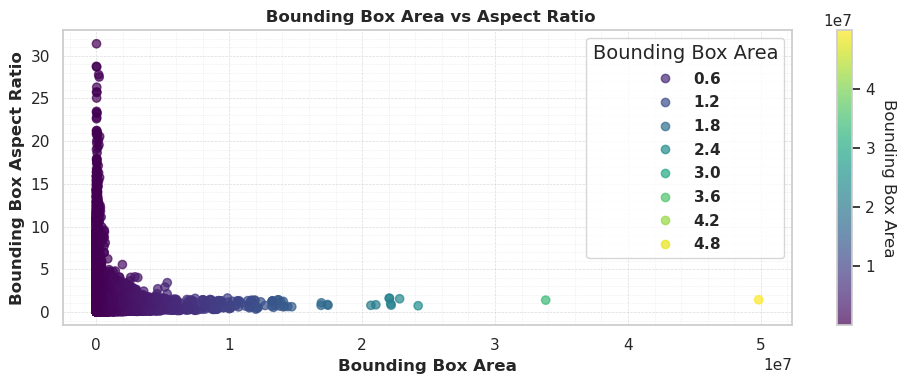

In [99]:
# Set the style for a better appearance
sns.set_style("whitegrid")

# Set the font family to Cambria
plt.rcParams['font.family'] = 'Cambria'

# Create a figure and axes with customized dimensions and colors
fig, ax = plt.subplots(figsize=(10, 4))
scatter = ax.scatter(train_annotations['bbox_area'], train_annotations['bbox_aspect_ratio'], c=train_annotations['bbox_area'], cmap='viridis', alpha=0.7)

# Customize the colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Bounding Box Area', rotation=270, labelpad=15)

# Set labels and title with bold font weight
ax.set_xlabel('Bounding Box Area', fontweight='bold')
ax.set_ylabel('Bounding Box Aspect Ratio', fontweight='bold')
ax.set_title(' Bounding Box Area vs Aspect Ratio', fontweight='bold')

# Customize grid and ticks
ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Adding legend with bold font weight
legend = ax.legend(*scatter.legend_elements(), title='Bounding Box Area', title_fontsize='14', prop={'weight': 'bold'})

# Display the plot
plt.tight_layout()
plt.show()


In [100]:
print("\nCategorywise Document Image Count.\n")
categorywise_image_count=img_cat_count.groupby('category_id', as_index=False)['image_id'].nunique()
categorywise_image_count['category_name']=train_categories['name']
categorywise_image_count.rename(columns={'image_id':'image_count'}, inplace=True)
categorywise_image_count = categorywise_image_count[['category_id', 'category_name', 'image_count']]
categorywise_image_count


Categorywise Document Image Count.



category_id category_name  image_count
0            0     paragraph        18955
1            1      text_box        19502
2            2         image         4441
3            3         table          892

<Axes: title={'center': 'Categories vs Number of document images they appear'}, xlabel='category_name', ylabel='image_count'>

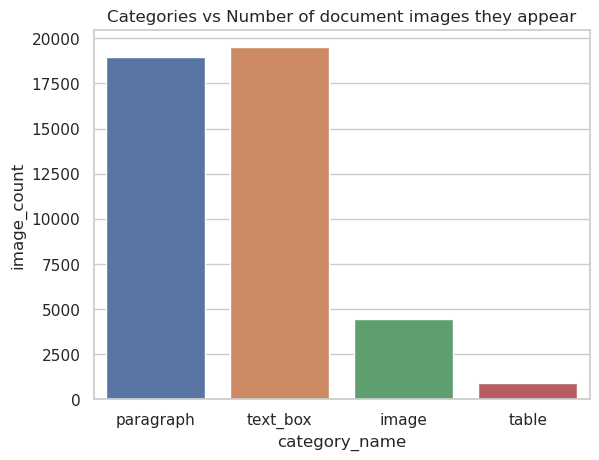

In [101]:
plt.title("Categories vs Number of document images they appear")
sns.barplot(x=categorywise_image_count['category_name'], y=categorywise_image_count['image_count'])

In [102]:
print("\nImagewise Category Count.\n")
imagewise_category_count=img_cat_count.groupby('image_id', as_index=False)[['paragraph', 'text_box', 'image', 'table']].sum()
imagewise_category_count.head()


Imagewise Category Count.



image_id  paragraph  text_box  image  table
0         0          2        50      1      0
1         1          0       205      0      1
2         2          0       177      0      1
3         3          0       177      0      1
4         4          1        68      3      0

In [103]:
bbox_area_count = train_annotations.groupby('bbox_area', as_index=False)['annotation_id'].count()
bbox_area_count.rename(columns={'annotation_id':'annotation_count'}, inplace=True)
print("\nTop 10 areas having maximum annotation count.\n")
bbox_area_count.sort_values(by='annotation_count', ascending=False,inplace=True)
bbox_area_count.head(10)


Top 10 areas having maximum annotation count.



bbox_area  annotation_count
301       648.0               421
2929     5320.0               419
362       756.0               383
1560     2880.0               375
315       672.0               368
675      1320.0               350
405       840.0               341
1829     3360.0               333
641      1260.0               330
988      1872.0               307

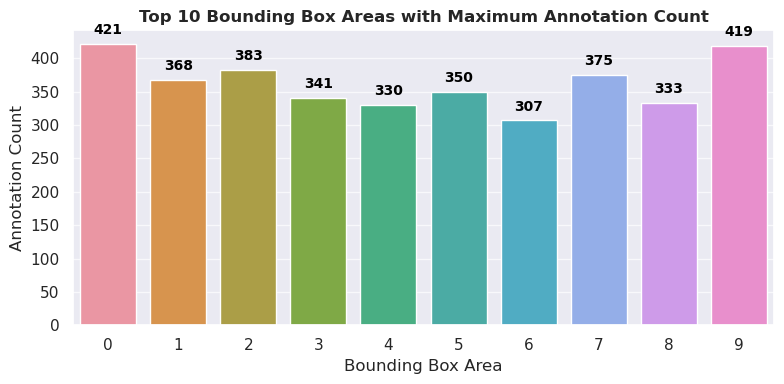

In [104]:
# Set up a more visually appealing style
sns.set_style("darkgrid")
sns.set_palette("viridis")
# Set the font family to Cambria
plt.rcParams['font.family'] = 'Cambria'
# Create a figure and axis with customized dimensions and colors
plt.figure(figsize=(8, 4))

# Plotting the top 10 areas with maximum annotation count
ax = sns.barplot(x='bbox_area', y='annotation_count', data=bbox_area_count.head(10))

# Adding annotations on top of the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points',
                fontsize=10, fontweight='bold', color='black')

# Set labels and title
plt.xlabel('Bounding Box Area')
plt.ylabel('Annotation Count')
plt.title('Top 10 Bounding Box Areas with Maximum Annotation Count', fontweight='bold', fontsize=12)

# Customize the x-axis tick labels to display as integers with comma separators
plt.xticks()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Adding grid
plt.grid(axis='y', alpha=0.7)


# Display the plot
plt.tight_layout()
plt.show()


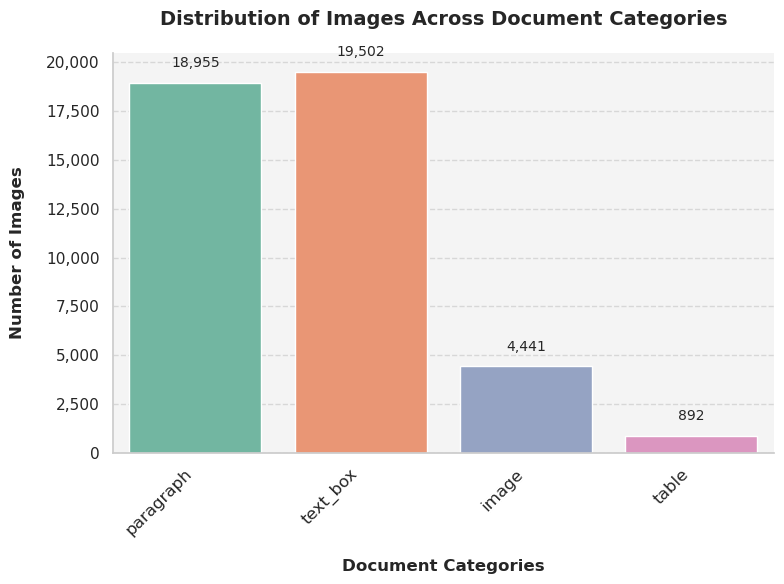

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set the style for the plot
sns.set_style("whitegrid")
# Set the font family to Cambria
plt.rcParams['font.family'] = 'Cambria'
plt.figure(figsize=(8, 6))  # Set the size of the figure

# Create a bar plot using seaborn with a different palette
ax = sns.barplot(x=categorywise_image_count['category_name'], y=categorywise_image_count['image_count'], palette="Set2")

# Add labels and title with Cambria font style and bold
font_style = {'fontname': 'Cambria', 'fontweight': 'bold'}

ax.set_xlabel("Document Categories", fontdict=font_style, fontsize=12, labelpad=15)
ax.set_ylabel("Number of Images", fontdict=font_style, fontsize=12, labelpad=15)
ax.set_title("Distribution of Images Across Document Categories", fontdict=font_style, fontsize=14, pad=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add data labels on top of the bars with better formatting
def format_func(value, tick_number):
    return f"{int(value):,}"
ax.yaxis.set_major_formatter(FuncFormatter(format_func))

for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10,
                xytext=(0, 9), textcoords='offset points')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Customize the background color of the plot
ax.set_facecolor('#f4f4f4')

# Remove spines
sns.despine()

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()  # Display the plot


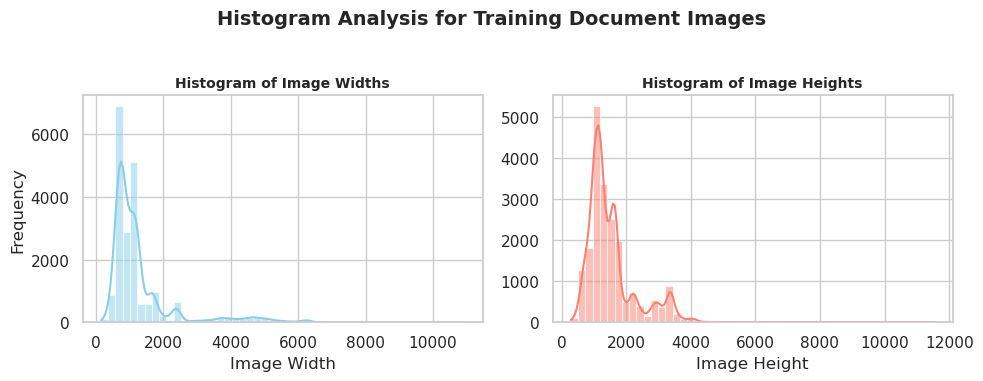

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded the data into train_metadata and train_annot_df

# Select relevant columns from train_metadata
trainmetadata = train_metadata[['image_id', 'width', 'height']]

# Set up a customized style using Seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(10, 4))
# Set the font family to Cambria
plt.rcParams['font.family'] = 'Cambria'
# Add a title for the entire plot
plt.suptitle("Histogram Analysis for Training Document Images", fontname='Cambria', fontsize=14, fontweight='bold')

# Create a subplot with two histograms side by side
plt.subplot(1, 2, 1)
sns.histplot(trainmetadata['width'], bins=50, color='skyblue', kde=True)
plt.title("Histogram of Image Widths", fontname='Cambria', fontsize=10, fontweight='bold')
plt.xlabel("Image Width", fontname='Cambria', fontsize=12)
plt.ylabel("Frequency", fontname='Cambria', fontsize=12)
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(trainmetadata['height'], bins=50, color='salmon', kde=True)
plt.title("Histogram of Image Heights", fontname='Cambria', fontsize=10, fontweight='bold')
plt.xlabel("Image Height", fontname='Cambria', fontsize=12)
plt.ylabel("", fontsize=12)  # Remove y-axis label for consistency
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the top margin for the title
plt.show()


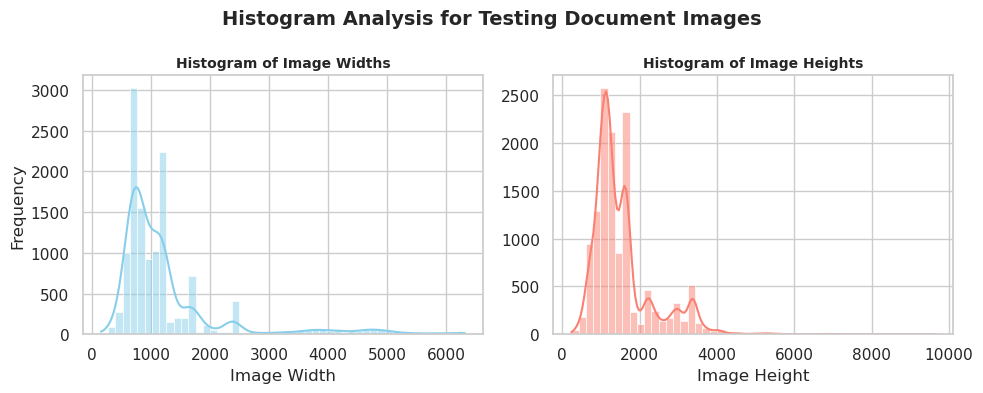

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded the data into train_metadata and train_annot_df

# Select relevant columns from train_metadata
testmetadata = test_metadata[['image_id', 'width', 'height']]

# Set up a customized style using Seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(10, 4))
# Set the font family to Cambria
plt.rcParams['font.family'] = 'Cambria'

# Add a title for the entire plot
plt.suptitle("Histogram Analysis for Testing Document Images", fontname='Cambria', fontsize=14, fontweight='bold')


# Create a subplot with two histograms side by side
plt.subplot(1, 2, 1)
sns.histplot(testmetadata['width'], bins=50, color='skyblue', kde=True)
plt.title("Histogram of Image Widths", fontname='Cambria', fontsize=10, fontweight='bold')
plt.xlabel("Image Width", fontname='Cambria', fontsize=12)
plt.ylabel("Frequency", fontname='Cambria', fontsize=12)
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(testmetadata['height'], bins=50, color='salmon', kde=True)
plt.title("Histogram of Image Heights", fontname='Cambria', fontsize=10, fontweight='bold')
plt.xlabel("Image Height", fontname='Cambria', fontsize=12)
plt.ylabel("", fontsize=12)  # Remove y-axis label for consistency
plt.grid(True)

plt.tight_layout()
plt.show()

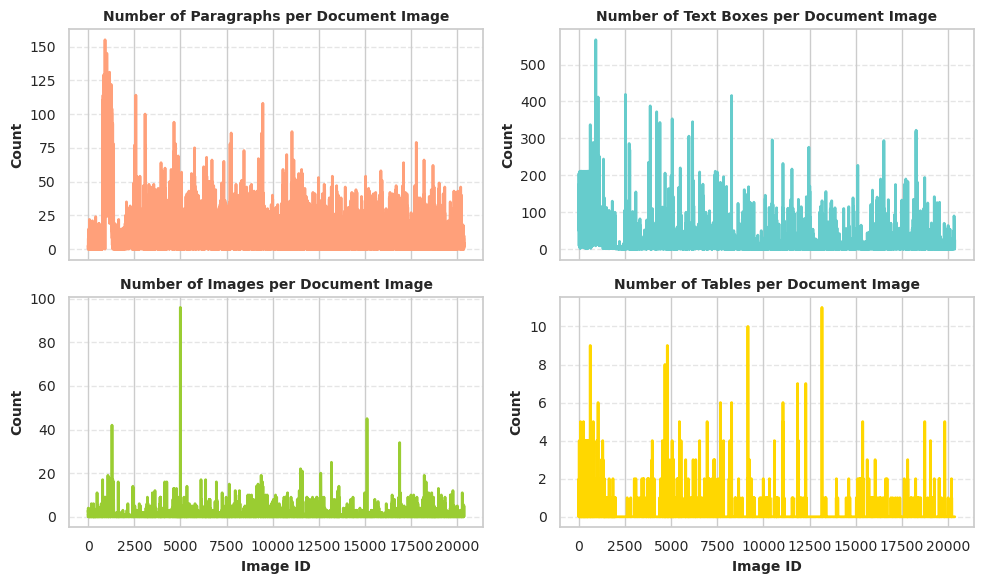

In [108]:
# Set up a more visually appealing style
sns.set_style("whitegrid")

# Set the font family to Cambria
plt.rcParams['font.family'] = 'Cambria'

# Define custom colors for the subplots
colors = ['#FFA07A', '#66CCCC', '#9ACD32', '#FFD700']

# Create a figure and subplots in a 2x2 grid with customized dimensions and colors
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

# Plotting the number of paragraphs per document image
sns.lineplot(ax=axs[0, 0], x=imagewise_category_count['image_id'], y=imagewise_category_count['paragraph'], linewidth=2, color=colors[0])
axs[0, 0].set_title("Number of Paragraphs per Document Image", fontweight='bold', fontsize=10)
axs[0, 0].set_ylabel("Count", fontweight='bold', fontsize=10)
axs[0, 0].tick_params(axis='both', which='major', labelsize=10)

# Plotting the number of text boxes per document image
sns.lineplot(ax=axs[0, 1], x=imagewise_category_count['image_id'], y=imagewise_category_count['text_box'], linewidth=2, color=colors[1])
axs[0, 1].set_title("Number of Text Boxes per Document Image", fontweight='bold', fontsize=10)
axs[0, 1].set_ylabel("Count", fontweight='bold', fontsize=10)
axs[0, 1].tick_params(axis='both', which='major', labelsize=10)

# Plotting the number of images per document image
sns.lineplot(ax=axs[1, 0], x=imagewise_category_count['image_id'], y=imagewise_category_count['image'], linewidth=2, color=colors[2])
axs[1, 0].set_title("Number of Images per Document Image", fontweight='bold', fontsize=10)
axs[1, 0].set_xlabel("Image ID", fontweight='bold', fontsize=10)
axs[1, 0].set_ylabel("Count", fontweight='bold', fontsize=10)
axs[1, 0].tick_params(axis='both', which='major', labelsize=10)

# Plotting the number of tables per document image
sns.lineplot(ax=axs[1, 1], x=imagewise_category_count['image_id'], y=imagewise_category_count['table'], linewidth=2, color=colors[3])
axs[1, 1].set_title("Number of Tables per Document Image", fontweight='bold', fontsize=10)
axs[1, 1].set_xlabel("Image ID", fontweight='bold', fontsize=10)
axs[1, 1].set_ylabel("Count", fontweight='bold', fontsize=10)
axs[1, 1].tick_params(axis='both', which='major', labelsize=10)

# Adding grid lines with lighter color
for row in axs:
    for ax in row:
        ax.grid(axis='y', alpha=0.5, linestyle='--')

# Adjusting spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [109]:
TRAIN_SPLIT = 0.99

In [110]:
n_dataset = len(train_metadata)
n_train = int(n_dataset * TRAIN_SPLIT)
print("n_dataset", n_dataset, "n_train", n_train, "n_val", n_dataset-n_train)

np.random.seed(SEED)

inds = np.random.permutation(n_dataset)
train_inds, valid_inds = inds[:n_train], inds[n_train:]

n_dataset 20365 n_train 20161 n_val 204


In [111]:
def convert_coco_to_detectron2_format(
    imgdir: Path,
    metadata_df: pd.DataFrame,
    annot_df: Optional[pd.DataFrame] = None,
    target_indices: Optional[np.ndarray] = None,
):

    dataset_dicts = []
    for _, train_meta_row in tqdm(metadata_df.iterrows(), total=len(metadata_df)):
        # Iterate over each image
        image_id, filename, width, height = train_meta_row.values

        annotations = []

        # If train/validation data, then there will be annotations
        if annot_df is not None:
            for _, ann in annot_df.query("image_id == @image_id").iterrows():
                # Get annotations of current iteration's image
                class_id = ann["category_id"]
                gt_masks = ann["gt_masks"]
                bbox_resized = [
                    float(ann["x_min"]),
                    float(ann["y_min"]),
                    float(ann["x_max"]),
                    float(ann["y_max"]),
                ]

                annotation = {
                    "bbox": bbox_resized,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": gt_masks,
                    "category_id": class_id,
                }

                annotations.append(annotation)

        # coco format -> detectron2 format dict
        record = {
            "file_name": str(imgdir/filename),
            "image_id": image_id,
            "width": width,
            "height": height,
            "annotations": annotations
        }

        dataset_dicts.append(record)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

In [112]:
DATA_REGISTER_TRAINING = "badlad_train"
DATA_REGISTER_VALID    = "badlad_valid"
DATA_REGISTER_TEST     = "badlad_test"

In [113]:
# Register Training data
if is_train:
    DatasetCatalog.register(
        DATA_REGISTER_TRAINING,
        lambda: convert_coco_to_detectron2_format(
            TRAIN_IMG_DIR,
            train_metadata,
            train_annot_df,
            target_indices=train_inds,
        ),
    )

    # Set Training data categories
    MetadataCatalog.get(DATA_REGISTER_TRAINING).set(thing_classes=thing_classes)

    dataset_dicts_train = DatasetCatalog.get(DATA_REGISTER_TRAINING)
    metadata_dicts_train = MetadataCatalog.get(DATA_REGISTER_TRAINING)

    print("dicts training size=", len(dataset_dicts_train))
    print("################")

  0%|          | 0/20365 [00:00<?, ?it/s]

dicts training size= 20161
################


In [114]:
# Register Validation data
if is_train or is_evaluate:
    DatasetCatalog.register(
        DATA_REGISTER_VALID,
        lambda: convert_coco_to_detectron2_format(
            TRAIN_IMG_DIR,
            train_metadata,
            train_annot_df,
            target_indices=valid_inds,
        ),
    )

    # Set Validation data categories
    MetadataCatalog.get(DATA_REGISTER_VALID).set(thing_classes=thing_classes)

    dataset_dicts_valid = DatasetCatalog.get(DATA_REGISTER_VALID)
    metadata_dicts_valid = MetadataCatalog.get(DATA_REGISTER_VALID)

    print("dicts valid size=", len(dataset_dicts_valid))
    print("################")

  0%|          | 0/20365 [00:00<?, ?it/s]

dicts valid size= 204
################


In [115]:
# Register Test Inference data
DatasetCatalog.register(
    DATA_REGISTER_TEST,
    lambda: convert_coco_to_detectron2_format(
        TEST_IMG_DIR,
        test_metadata,
    )
)

# Set Test data categories
MetadataCatalog.get(DATA_REGISTER_TEST).set(
    thing_classes=thing_classes_test
)

dataset_dicts_test = DatasetCatalog.get(DATA_REGISTER_TEST)
metadata_dicts_test = MetadataCatalog.get(DATA_REGISTER_TEST)

  0%|          | 0/13000 [00:00<?, ?it/s]

In [116]:
print("#### DATA REGISTERED ####")

#### DATA REGISTERED ####


In [117]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [T.RandomBrightness(0.8, 1.2),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(
        image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])

    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict

In [118]:
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [119]:
if is_train:
    cfg = get_cfg()

    # config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
    config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

    cfg.merge_from_file(model_zoo.get_config_file(config_name))

    cfg.DATASETS.TRAIN = (DATA_REGISTER_TRAINING,)
    cfg.DATASETS.TEST = (DATA_REGISTER_VALID,)

    # to evaluate during training, you have to implement `build_evaluator()` method of the trainer.
    # https://github.com/facebookresearch/detectron2/blob/94113be6e12db36b8c7601e13747587f19ec92fe/detectron2/engine/defaults.py#L561
    # cfg.TEST.EVAL_PERIOD = 500

    cfg.DATALOADER.NUM_WORKERS = 0
    #cfg.TEST.EVAL_PERIOD = 500
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
    if (is_resume_training):
        print("#### SETTING PRETRAINED WEIGHTS TO RESUME TRAINING ####")
        cfg.MODEL.WEIGHTS = str(PRETRAINED_PATH)
    else:
        print("#### TRAINING MODEL FROM SCRATCH ####")

    cfg.SOLVER.AMP.ENABLED = True
    cfg.SOLVER.IMS_PER_BATCH = 16
    cfg.SOLVER.BASE_LR = 0.001

    cfg.SOLVER.WARMUP_ITERS = 5

    # Maximum number of iterations
    cfg.SOLVER.MAX_ITER = 6100

    # cfg.SOLVER.STEPS = (500, 1000) # must be less than MAX_ITER

    cfg.SOLVER.GAMMA = 0.05

    # Small value == Frequent save need a lot of storage.
    cfg.SOLVER.CHECKPOINT_PERIOD = 1000
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

    # Create Output Directory
    cfg.OUTPUT_DIR = str(OUTPUT_DIR)
    print("creating cfg.OUTPUT_DIR -> ", cfg.OUTPUT_DIR)
    OUTPUT_DIR.mkdir(exist_ok=True)

#### SETTING PRETRAINED WEIGHTS TO RESUME TRAINING ####
creating cfg.OUTPUT_DIR ->  output


In [120]:
torch.cuda.empty_cache()

In [121]:
!nvidia-smi

Sat Aug  5 15:20:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    46W /  70W |   4086MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [122]:
torch.cuda.empty_cache()

In [123]:
if is_train:
    trainer = DefaultTrainer(cfg) if not is_augment else AugTrainer(cfg)
        
    trainer.resume_or_load(resume=is_resume_training)

    trainer.train()
    
    print("#### TRAINING COMPLETE ####")
    _ = trainer.model.train(False)  # turn off training
    
    FileLink(str(OUTPUT_MODEL))

[08/05 15:20:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/20365 [00:00<?, ?it/s]

[08/05 15:22:44 d2.data.build]: Removed 0 images with no usable annotations. 20161 images left.
[08/05 15:22:46 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 207645       |  text_box  | 201831       |   image    | 10190        |
|   table    | 1348         |            |              |            |              |
|   total    | 421014       |            |              |            |              |
[08/05 15:22:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/05 15:22:46 d2.data.build]: Using training sampler TrainingSampler
[08/05 15:22:46 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializ

  0%|          | 0/20365 [00:00<?, ?it/s]

[08/05 15:32:27 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 1938         |  text_box  | 2035         |   image    | 107          |
|   table    | 7            |            |              |            |              |
|   total    | 4087         |            |              |            |              |
[08/05 15:32:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/05 15:32:27 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/05 15:32:27 d2.data.common]: Serializing 204 elements to byte tensors and concatenating them all ...
[08/05 15:32:27 d2.data.common]: Serialized dataset takes 0.63 MiB
WARNING [08/05 15:3

                                    0            1            2            3   \
data_time                     1.223361     0.914182     0.924505     1.419293   
eta_seconds                9683.547489  9225.993276  9144.159329  9834.599857   
fast_rcnn/cls_accuracy        0.916992     0.927246     0.916504     0.921875   
fast_rcnn/false_negative      0.173828     0.140625     0.164062     0.169922   
fast_rcnn/fg_cls_accuracy     0.806641     0.833984     0.806641     0.804688   
iteration                    19.000000    39.000000    59.000000    79.000000   
loss_box_reg                  0.337711     0.312286     0.328925     0.347270   
loss_cls                      0.200178     0.179895     0.203404     0.184402   
loss_mask                     0.209713     0.197763     0.200268     0.206421   
loss_rpn_cls                  0.025446     0.022140     0.019050     0.018365   
loss_rpn_loc                  0.135052     0.114501     0.125435     0.134836   
lr                          

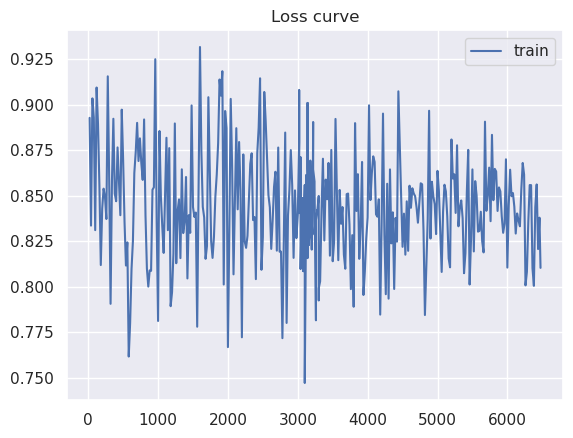

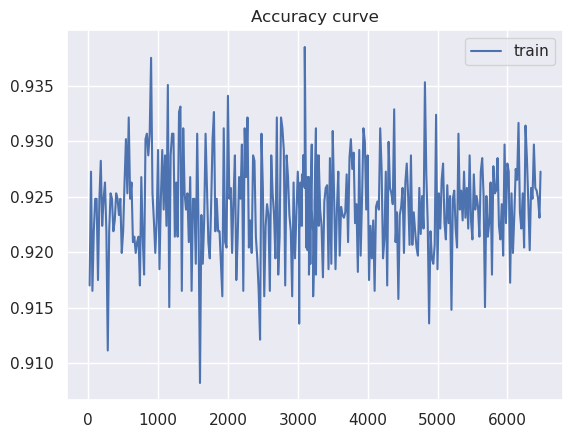

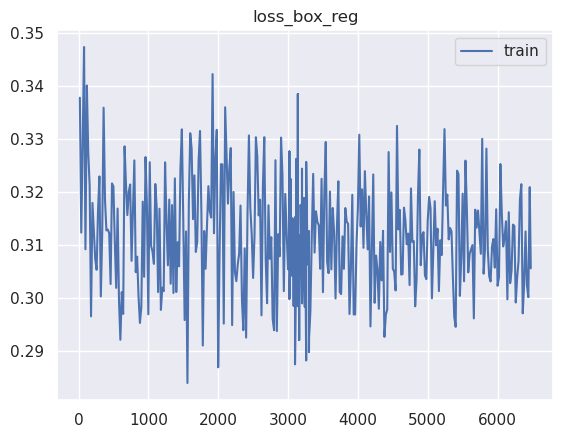

In [50]:
if is_train:
    # Load metrics
    metrics_df = pd.read_json(
        OUTPUT_DIR/"metrics.json", orient="records", lines=True
    )
    mdf = metrics_df.sort_values("iteration")
    #.tail(3)
    print(mdf.head(30).T)

    # Plot loss
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["total_loss"].isna()]
    ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")

    if "validation_loss" in mdf.columns:
        mdf2 = mdf[~mdf["validation_loss"].isna()]
        ax.plot(mdf2["iteration"], mdf2["validation_loss"],
                c="C1", label="validation")

    ax.legend()
    ax.set_title("Loss curve")
    plt.show()

    # Plot Accuracy
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
    ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"],
            c="C0", label="train")

    ax.legend()
    ax.set_title("Accuracy curve")
    plt.show()

    # Plot Bounding Box regressor loss
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["loss_box_reg"].isna()]
    ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")

    ax.legend()
    ax.set_title("loss_box_reg")
    plt.show()

In [124]:
if Path("/kaggle/working/output/model_final.pth").exists:
    display(FileLink("output/model_final.pth"))

/kaggle/working/output/model_final.pth

In [ ]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()                             


In [66]:
inf_cfg = get_cfg()

config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

inf_cfg.merge_from_file(model_zoo.get_config_file(config_name))
inf_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
inf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
inf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
inf_cfg.MODEL.DEVICE = "cuda"

inf_cfg.DATALOADER.NUM_WORKERS =  0 # lower this if CUDA overflow occurs
inf_cfg.MODEL.WEIGHTS = str(MODEL_PATH)

In [68]:
BATCH = 10  # lower this if CUDA overflow occurs
test_loader = build_detection_test_loader(inf_cfg, DATA_REGISTER_TEST, batch_size=BATCH)

  0%|          | 0/13000 [00:00<?, ?it/s]

[08/04 21:09:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/04 21:09:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/04 21:09:56 d2.data.common]: Serializing 13000 elements to byte tensors and concatenating them all ...
[08/04 21:09:56 d2.data.common]: Serialized dataset takes 1.97 MiB


In [69]:
ACCEPTANCE_THRESHOLD = 0.6  # for all categories

In [70]:
predictor = DefaultPredictor(inf_cfg)
print(predictor)

[08/04 21:09:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...


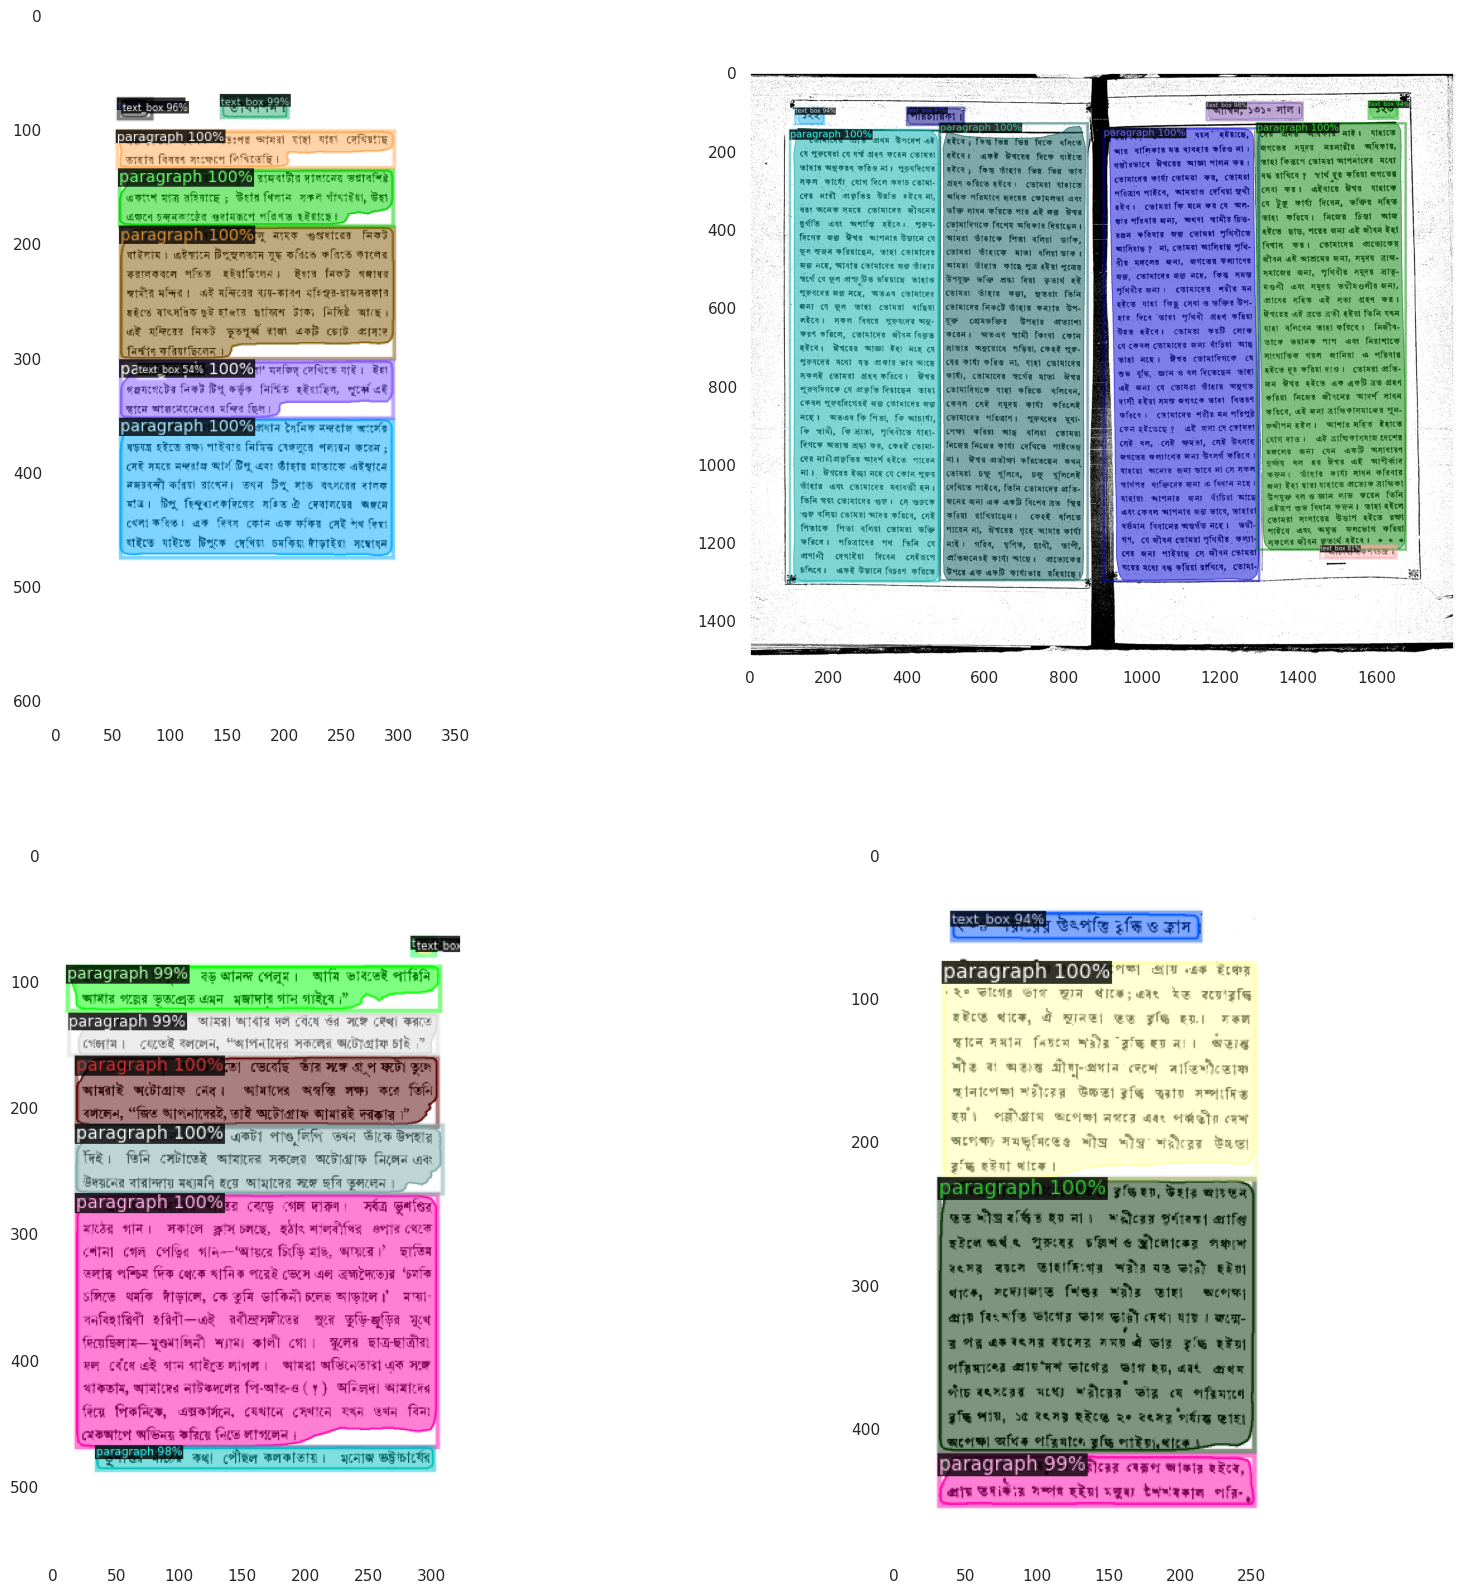

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
indices = [ax[0][0], ax[1][0], ax[0][1], ax[1][1]]

# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = np.random.choice(dataset_dicts_test, NUM_TEST_SAMPLES)

for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_test, scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu")
    )
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)